## Pneumonia classificaton using Transfer Learning - Base Model

This will be the **base model** using VGG16 pretrained model.

The base model will not have any data augmentation.


## Import Packages

In [1]:
# import necessary packages
import os
import warnings
import math
import pandas as pd
import numpy as np
from numpy.random import seed
from glob import glob

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# for deep learning
import tensorflow as tf
from tensorflow.keras.models import (
    save_model, 
    load_model
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import(
    Dense,
    GlobalAveragePooling2D,
)
# for metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    plot_confusion_matrix, 
    auc,
    roc_auc_score,
    roc_curve,
)
# ignore warnings
warnings.filterwarnings("ignore")
print("[INFO] All required packages are ready...")


[INFO] All required packages are ready...


### Check for GPU access

In [ ]:
# check TF vesion
print("Tensorflow version: ", tf.__version__)

# check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

if len(physical_devices) == 0:
    print("GPU device not found. Running on CPU.")
else:
    print('Found GPU at: {}'.format(physical_devices))


Tensorflow version:  2.6.0
Num GPUs: 1
Found GPU at: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set reproducibility seed

In [ ]:
# Reproducibility
def set_seed(seed=34):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    

print("[INFO] Reproducubilities are ready...")
set_seed(34)


[INFO] Reproducubilities are ready...


### Mount google drive

In [ ]:
# mount google drive
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set working directory

In [ ]:
import sys

# set working directory for google colab
path = '/content/drive/MyDrive/Colab Notebooks'
sys.path.insert(0, path)
print("[INFO]  Working directory path is set up...")


[INFO]  Working directory path is set up...


### Download dataset and unzipped it

In [ ]:
# download data from kaggle api
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d "tolgadincer/labeled-chest-xray-images" -p "~/workspace/ml-apps/input/"


In [ ]:
from utils.unzip_file import unzip_file

# path where our data resides
file_path = '/content/drive/MyDrive/input/chest_xray.zip'

unzip_file(file_path)
print("[INFO]  Data has been unzipped...")


# Load Data

In [ ]:
# set image data directories
MAIN_DIR = "/content/"
TRAIN_DIR = os.path.join(MAIN_DIR, 'train')
TEST_DIR = os.path.join(MAIN_DIR, 'test')

# look into train folder for .jpg files for normal and pneumonia images
NORMAL_TRAIN_IMAGES = os.path.join(MAIN_DIR, "train/NORMAL/")
PNEUMONIA_TRAIN_IMAGES = os.path.join(MAIN_DIR, "train/PNEUMONIA/")

# look into train folder for .jpg files for normal and pneumonia images
NORMAL_TEST_IMAGES = os.path.join(MAIN_DIR, "NORMAL")
PNEUMONIA_TES_IMAGES = os.path.join(MAIN_DIR, "PNEUMONIA")

print("[INFO] Data directories are ready...")


[INFO] Data directories are ready...


In [ ]:
# print some image file names
train_normal_names = os.listdir(NORMAL_TRAIN_IMAGES)
print(train_normal_names[:3])


['NORMAL-8311712-0001.jpeg', 'NORMAL-5015362-0001.jpeg', 'NORMAL-5740995-0001.jpeg']


In [ ]:
# let's verify we have two classes
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
print('Number of classes: ', num_classes)


Number of classes:  2


# Data Preprocessing

### Set somve variables

In [ ]:
# set our image size
image_size = (224, 224)

# Initiate an input layer to pass our image size
input_shape = image_size + (3, )

# ste batch size
batch_size = 32

# initial number of epochs
epochs = 10

# set class labels
class_names = ['NORMAL', 'PNEUMONIA']

# set a seed for data generators
data_seed = 1

# Set variables for initial learning rate
learning_rate = 1e-3

# set initial optimizer
opt = Adam(
    learning_rate=learning_rate,
    amsgrad=False,
    name='Adam',
)

# set metrics and loss for model training
metrics = ['accuracy']
loss = ['binary_crossentropy']

print("[INFO] Some useful variables have been declared...")


[INFO] Some useful variables have been declared...


## Generate data batches for train/test images

In [ ]:
# Generate batches of tensor image data with real-time data augmentation
# Takes the path to a directory & generates batches of augmented data
# Training/Validation Split with ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
)


def get_train_generator(
    dir_path, image_size, batch_size, class_names, seed, shuffle=True
):
    """
    Initiating data augment generator that rescale and resizes.
    Scale all pixel intensities to the range [0, 1].
    """
    # initialize the training generator
    train_generator_ = datagen.flow_from_directory(
        directory=dir_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        subset="training",
        classes=class_names,
        seed=seed,
        shuffle=shuffle,
    )

    return train_generator_


def get_val_generator(
    dir_path, image_size, batch_size, class_names, seed, shuffle=False
):
    """
    initiating data augment generator that rescale and resizes.
    Scale all pixel intensities to the range [0, 1].
    """
    # initialize the training generator
    val_generator_ = datagen.flow_from_directory(
        directory=dir_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        subset="validation",
        classes=class_names,
        seed=seed,
        shuffle=shuffle,
    )

    return val_generator_

def get_test_generator(
    dir_path, image_size, batch_size, class_names, seed, shuffle=False
):
    """
    initiating data augment generator that rescale and resizes.
    Scale all pixel intensities to the range [0, 1].
    """
    # initialize the training data augmentation object
    datagen_test = ImageDataGenerator(
        rescale=1./255,
    )

    # initialize the training generator
    test_generator_ = datagen_test.flow_from_directory(
        directory=dir_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        classes=class_names,
        seed=seed,
        shuffle=shuffle,
    )

    return test_generator_

print("[INFO] Pipeline for data batches has been generated...")


[INFO] Pipeline for data batches has been generated...


In [ ]:
print("[INFO] Getting information for data generators...")

# get training images
train_data = get_train_generator(
    TRAIN_DIR,
    image_size,
    batch_size,
    class_names,
    data_seed,
)

# get val images
val_data = get_val_generator(
    TRAIN_DIR,
    image_size,
    batch_size,
    class_names,
    data_seed,
)

# get test images
test_data = get_test_generator(
    TEST_DIR,
    image_size,
    batch_size,
    class_names,
    data_seed,
)


[INFO] Getting information for data generators...
Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Check shape of image batches

In [ ]:
# see the shape of the image batches
for image_batch, labels_batch in train_data:
    print('\nImage Shape: ')
    print(image_batch.shape)
    print(labels_batch.shape)
    break



Image Shape: 
(32, 224, 224, 3)
(32,)


The image_batch is a tensor of the shape (32, 224, 224, 3).

This is a batch of 32 images of shape 224x224x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# Modeling and Training

## Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model


def get_model():
    '''load the base model from the pre-trained model VGG16.
       Load weights pre-trained on ImageNet.
       Do not include the ImageNet classifier at the top.
    '''
    # load vgg16 pretrained model
    pretrained_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        classes=1000,
        classifier_activation='softmax'
    )

    return pretrained_model

# get pretraind model
base_model = get_model()

# base model architecture
print("[INFO] Summary of the pretrained base model architecture.\n")
base_model.summary()


[INFO] Summary of the pretrained base model architecture.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bl

In [ ]:
# check available layers
base_layers = len(base_model.layers)
print("[INFO] There are a total of", base_layers, "available layers.")


[INFO] There are a total of 19 available layers.


## Feature extraction

### Freeze the convolutional base

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
print("[INFO] Base model layers have been freeze...")
for layer in base_model.layers:
    layer.trainable = False


[INFO] Base model layers have been freeze...


In [ ]:
# how many trainable varibles we have
train_var = len(base_model.trainable_variables)
print("[INFO] There are", train_var , "trainable variables.")


[INFO] There are 0 trainable variables.


In [ ]:
# Let's confirm our layers are not trainable
# Should be noted as False = Not trainable
for (i, layer) in enumerate(base_model.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)


0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


## Add a classification head to the base model

In [ ]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 512)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 512)


## Construct a top model and compile the model

In [ ]:
# Construct a new model on top of base model


def head_model():
    '''
    Instantiate a Sequential model without an input shape
    construct the head model that will be placed on top of the
    the pretrained base model
    '''
    model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(1, activation='sigmoid', name='prediction_layer'),
        ],
        name='head_model'
    )

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=metrics,
    )

    return model


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = head_model()
print("[INFO] Getting Head model...")
print("[INFO] Classification head model has been compiled ...")
model.summary()


[INFO] Getting Head model...
[INFO] Classification head model has been compiled ...
Model: "head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# how many trainable varibles we have
train_var = len(model.trainable_variables)
print("[INFO] There are", train_var , "trainable variables.")


[INFO] There are 2 trainable variables.


In [ ]:
# show and save our base model architecture
!mkdir -p output/model_architecture

head_model_arch = plot_model(
    model,
    to_file="output/model_architecture/base_model_architecture-01.png",
    show_shapes=True,
    expand_nested=True,
)


# Train the model

In [ ]:
# build model and train it
print("[INFO] Training head model...")
start = datetime.now()

# train model
head_hist = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    verbose=1,
)

# get the training time
training_time = datetime.now() - start
print("Training completed in time: ", training_time)


[INFO] Training head model...
Epoch 1/10
148/148 [==============================] - 61s 403ms/step - loss: 0.5034 - accuracy: 0.7425 - val_loss: 0.4361 - val_accuracy: 0.7586
Epoch 2/10
148/148 [==============================] - 57s 383ms/step - loss: 0.3966 - accuracy: 0.7934 - val_loss: 0.3609 - val_accuracy: 0.8103
Epoch 3/10
148/148 [==============================] - 56s 381ms/step - loss: 0.3371 - accuracy: 0.8558 - val_loss: 0.3156 - val_accuracy: 0.8621
Epoch 4/10
148/148 [==============================] - 56s 380ms/step - loss: 0.2993 - accuracy: 0.8854 - val_loss: 0.2876 - val_accuracy: 0.8927
Epoch 5/10
148/148 [==============================] - 56s 381ms/step - loss: 0.2744 - accuracy: 0.9004 - val_loss: 0.2670 - val_accuracy: 0.8927
Epoch 6/10
148/148 [==============================] - 56s 379ms/step - loss: 0.2555 - accuracy: 0.9110 - val_loss: 0.2528 - val_accuracy: 0.8985
Epoch 7/10
148/148 [==============================] - 56s 377ms/step - loss: 0.2406 - accuracy: 0.91

### Save the model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p output/saved_model

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('output/saved_model/base_model_full-01.h5')


### Check our training history values

In [ ]:
# put on a dataframe our model history values
hist_df = pd.DataFrame(data=head_hist.history)
hist_df


,loss,accuracy,val_loss,val_accuracy
0,0.503358,0.742463,0.436134,0.758621
1,0.396615,0.793418,0.360944,0.810345
2,0.337086,0.855839,0.315649,0.862069
3,0.299289,0.885350,0.287624,0.892720
4,0.274405,0.900425,0.267024,0.892720
5,0.255498,0.911040,0.252824,0.898467
6,0.240552,0.915074,0.240921,0.900383
7,0.229117,0.919108,0.229562,0.913793
8,0.219208,0.923567,0.221775,0.913793
9,0.210710,0.928025,0.217236,0.913793


# Plot Learning curves

Plot learning curves to check our training/validation performance


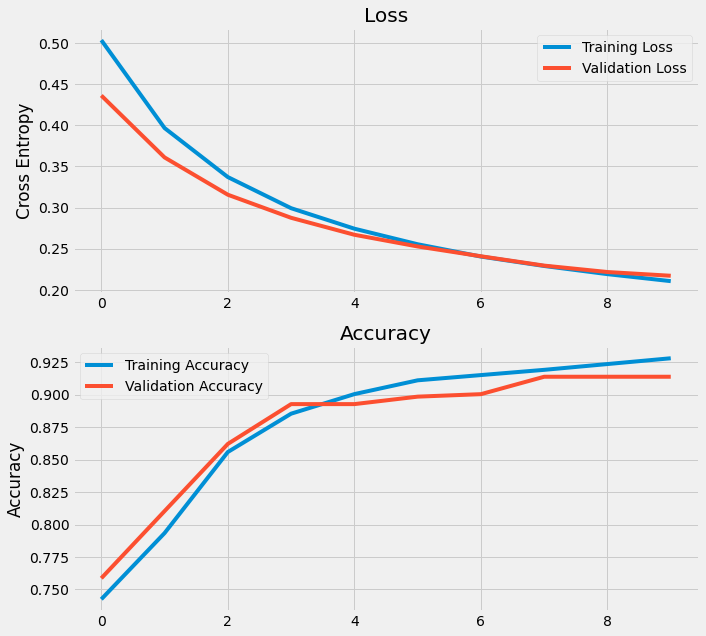

In [ ]:
# let's take a look of our base model performance for 12 epochs
!mkdir -p output/plots

def plot_model_performance(head_hist):
    """
    plot the performance history of our first model
    """
    # get loss scores
    loss = head_hist.history["loss"]
    val_loss = head_hist.history["val_loss"]
    # get accurcay scores
    acc = head_hist.history["accuracy"]
    val_acc = head_hist.history["val_accuracy"]
    # plot all plots
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(10, 10))
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend(loc="best")
    plt.ylabel("Cross Entropy")
    plt.title("Loss")
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.plot(acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend(loc="best")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    # save plot
    plt.savefig("output/plots/learning_curves_for_base_model-01", dpi=300)
    plt.show()


plot_model_performance(head_hist)


### Evaluate model on test data

In [ ]:
# Evaluate the model on the test data using 'evaluate'
print("[INFO] Evaluate on test data...")
test_loss, test_accuracy = model.evaluate(
    test_data,
    batch_size=batch_size,
)

# round test_loss to 3 decimals and test accuracy to 2
test_loss = round(test_loss, 3)
test_accuracy = round(test_accuracy*100, 2)

# print model evaluation results
print('test loss: ', test_loss)
print('test acc:', test_accuracy)


[INFO] Evaluate on test data...
20/20 [==============================] - 8s 406ms/step - loss: 0.3880 - accuracy: 0.8077
test loss:  0.388
test acc: 80.77


In [ ]:
# set threshold of 0.5 if value > 0.5 == class 1 [PNEUMONIA]
# if not belongs to class 0 [NORMAL]
threshold = 0.5
test_data.reset()

# real predictions not between 0 and 1. 
Y_pred = model.predict(
    test_data, 
    batch_size=batch_size,
    verbose=1)

# getting values for our threshold between 0 and 1
y_pred = np.where(Y_pred > threshold, 1, 0)
# print(y_pred)
# print(y_pred_thresh)


20/20 [==============================] - 6s 286ms/step


### Classification Report

In [ ]:
classification_report = classification_report(
    test_data.classes,
    y_pred,
    target_names=class_names,
)

print(classification_report)


              precision    recall  f1-score   support

      NORMAL       0.95      0.51      0.67       234
   PNEUMONIA       0.77      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624



### Confusion Matrix

Normal cases correctly Detected - (True Negatives):  120
Normal cases incorrectly Detected when is Pneumonia - (False Positives):  114
Pneumonia cases correctly Detected - (True Positives):  384
Pneumonia cases incorrectly Detected when is Normal -  (False Negatives):  6
Total Pneumonia cases:  390
Total Normal cases:  234




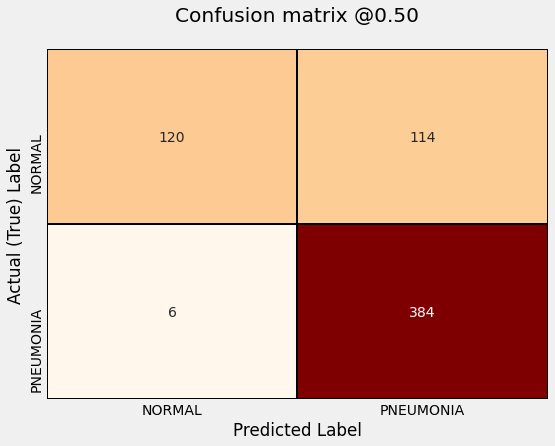

In [ ]:
group_names = ['TN', 'FP', 'FN', 'TP']
cm = confusion_matrix(test_data.classes, y_pred)


def plot_matrix(cm):
    plt.figure(figsize=(8, 6))
    plt.title('Confusion matrix @0.50\n')
    heatmap = sns.heatmap(
            cm,
            cmap='OrRd',
            linecolor='black',
            linewidths=1,
            annot=True,
            cbar=False,
            fmt='',
            xticklabels=class_names,
            yticklabels=class_names
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual (True) Label')
    plt.savefig('output/plots/confusion_matrix_base_model-01', dpi=300)

    return heatmap


plot_matrix(cm)
print('Normal cases correctly Detected - (True Negatives): ', cm[0][0])
print('Normal cases incorrectly Detected when is Pneumonia - (False Positives): ', cm[0][1])
print('Pneumonia cases correctly Detected - (True Positives): ', cm[1][1])
print('Pneumonia cases incorrectly Detected when is Normal -  (False Negatives): ', cm[1][0])
print('Total Pneumonia cases: ', np.sum(cm[1]))
print('Total Normal cases: ', np.sum(cm[0]))
print('\n')
plt.show()


# AUC, Sensitivity and Specificity scores

Since we know that our data is imbalanced.  Accuracy might not be the best model evaluation metric every time.  It can convey the health of a model well only when all the classes have similar prevalence in the data.  Thus, when the classes’ distribution is imbalanced, accuracy is not a good model evaluation metric.
For this reason we will rely on Sensitivity and Specificity as well as AUC ROC Scores.


In [ ]:
TN, FP, FN, TP = cm.ravel()

accuracy = (TP + TN)/(TP + TN + FN + FP)
sensitivity = (TP)/(TP + FN)
specificity = (TN)/(TN + FP)
prevalance = np.sum(test_data.classes)/len(test_data.classes)

print("Metrics:\n")
print("accuracy: {:.2%}".format(accuracy))
# positive cases (pneumonia [1]) predicted correctly
print("sensitivity: {:.2%}".format(sensitivity))
# negative casse (normal [0]) predicted correctly
print("specificity: {:.2%}".format(specificity))
# 
print("prevalance: {:.2%}".format(prevalance))

# 
AUC = roc_auc_score(test_data.classes, y_pred)
print("AUC ROC SCORE: {:.2%}".format(AUC))


Metrics:

accuracy: 80.77%
sensitivity: 98.46%
specificity: 51.28%
prevalance: 62.50%
AUC ROC SCORE: 74.87%


As we already know from the EDA section, this dataset is highly unbalanced.  There is an imbalance in the accuracy for pneumonia and normal predictions.  This is because the prevalence of pneumonia in this dataset is high.

We can determine that in 81% of the cases this model is predicting right for both cases.

That is why we won't rely on accuracy as an overall metric for this model.  We could measure both the sensitivity and specificity.

We have a low prevalance of 63% because the proportion of normal cases is low.  

The sensitivity indicates that out of 100 detections of pneumonia cases our model will predict the class 1 just about right in 98% of the time.  That is, out of 100 pneumonia cases 98 will be predicted right and 2 pneumonia cases will be wrongly predicted as normal cases.

However, the specificity out of 100 predictions regarding the normal cases, it will predict just about right those cases 51% of the time.  Yet, it will predict wrong about 49.

Meaning, out of 100 normal cases 51 will be predicted right but it will missed 49 cases and will end up being predicted as pneumonia cases.

**Note**: These initial base model is good but not great. We know the dataset is imbalanced.  Therefore, let'see if we can tuned this model a bit so that we can get better metrics.

# References

[Transfer learning and fine-tuning - tensorflow tutorials](https://www.tensorflow.org/tutorials/images/transfer_learning)

[Fine tuning with Keras and Deep Learning - tutorial](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)

[writing your own callbacks - tensorflow tutorials](https://www.tensorflow.org/guide/keras/custom_callback#setup)

[Data Augmentation in Medical Images](https://towardsdatascience.com/data-augmentation-in-medical-images-95c774e6eaae)